In [1]:
%pip install accelerate peft transformers trl unsloth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.7/192.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.6 

In [2]:
!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, PeftModel

2025-04-22 09:51:18.366758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745315478.662005      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745315478.735122      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Load model directly

tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-3B-Instruct")
model = AutoModelForCausalLM.from_pretrained(
    "unsloth/Llama-3.2-3B-Instruct",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto" if torch.cuda.is_available() else "cpu"
)

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/945 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

In [5]:
# Set up LoRA configuration

peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)

In [6]:
# Apply LoRA adapters

model = get_peft_model(model, peft_config)

In [7]:
train_dataset = load_dataset("json", data_files="/kaggle/input/legal-in/train.jsonl", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
len(train_dataset)

7080

In [9]:
test_dataset = load_dataset("json", data_files="/kaggle/input/legal-in/IN-Abs_test_data.jsonl", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [10]:
len(test_dataset)

100

In [11]:
# Function to prepare data for training

def preprocess_function(examples):
    inputs = examples["input"]
    targets = examples["output"]
    
    model_inputs = tokenizer(inputs, max_length=512, padding="max_length", truncation=True)
    labels = tokenizer(targets, max_length=512, padding="max_length", truncation=True)
    
    # Replace padding token id with -100 so they're ignored in loss computation
    
    labels["input_ids"] = [
        [(label if label != tokenizer.pad_token_id else -100) for label in labels_example]
        for labels_example in labels["input_ids"]
    ]
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [12]:
# Format and prepare train dataset

tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/7080 [00:00<?, ? examples/s]

In [13]:
# Format and prepare test dataset

tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [14]:
training_args = TrainingArguments(
    output_dir="llama-3-3b-sft-output",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=2e-6,
    num_train_epochs=10,
    logging_steps=1,
    save_strategy="no",  
    eval_strategy="epoch", 
    fp16=torch.cuda.is_available(),
    report_to="none",
    warmup_ratio=0.1,
    weight_decay=0.01,
    load_best_model_at_end=False, 
    logging_dir="./logs",
    logging_strategy="epoch",
)


In [15]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [16]:
# Define compute_metrics function for evaluation

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    labels = [[label if label != -100 else tokenizer.pad_token_id for label in l] for l in labels]
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = {
        "mean_pred_length": sum(len(pred.split()) for pred in decoded_preds) / len(decoded_preds),
        "mean_label_length": sum(len(label.split()) for label in decoded_labels) / len(decoded_labels)
    }

    try:
        from rouge_score import rouge_scorer
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
        for pred, label in zip(decoded_preds, decoded_labels):
            scores = scorer.score(label, pred)
            for metric in rouge_scores:
                rouge_scores[metric].append(scores[metric].fmeasure)
        for metric, scores in rouge_scores.items():
            result[metric] = sum(scores) / len(scores)
    except ImportError:
        pass

    return result

In [17]:
# Set up the Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/tmp/ipykernel_31/3553619141.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [18]:
# Start training

from accelerate import Accelerator
accelerator = Accelerator()
trainer.accelerator = accelerator
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.168900,2.025116
2,1.959000,1.916591
3,1.891500,1.873821
4,1.856200,1.847461
5,1.832800,1.829497
6,1.815200,1.816909
7,1.803700,1.808973
8,1.795900,1.804181
9,1.790800,1.801214
10,1.788100,1.800275


TrainOutput(global_step=8850, training_loss=1.8702019746424787, metrics={'train_runtime': 38791.647, 'train_samples_per_second': 1.825, 'train_steps_per_second': 0.228, 'total_flos': 6.183589980930048e+17, 'train_loss': 1.8702019746424787, 'epoch': 10.0})

In [19]:
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 1.8002753257751465, 'eval_runtime': 25.0293, 'eval_samples_per_second': 3.995, 'eval_steps_per_second': 1.998, 'epoch': 10.0}


In [20]:
# Save the fine-tuned model

trainer.model.save_pretrained("llama-3-3b-finetuned")
tokenizer.save_pretrained("llama-3-3b-finetuned")

('llama-3-3b-finetuned/tokenizer_config.json',
 'llama-3-3b-finetuned/special_tokens_map.json',
 'llama-3-3b-finetuned/tokenizer.json')

In [21]:
# Generate predictions on test dataset
def generate_predictions(model, tokenizer, test_dataset, output_file="predictions.jsonl"):
    predictions = []
    
    for example in test_dataset:
        input_text = example["input"]
        ground_truth = example["output"]
        
        # Format the prompt as in training
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=1024)
        if torch.cuda.is_available():
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        # Generate summary
        with torch.no_grad():
            output_ids = model.generate(
                **inputs,
                max_new_tokens=512,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                pad_token_id=tokenizer.pad_token_id
            )
        
        # Decode the output
        prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        
        predictions.append({
            "input": input_text,
            "ground_truth": ground_truth,
            "prediction": prediction
        })
    
    # Save predictions to file
    with open(output_file, "w", encoding="utf-8") as f:
        for pred in predictions:
            f.write(json.dumps(pred) + "\n")
    
    return predictions

In [22]:
# Load the full model for inference (merging LoRA weights)

merged_model = PeftModel.from_pretrained(model, "llama-3-3b-finetuned")
merged_model = merged_model.merge_and_unload()  # Merge LoRA weights with base model

/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:599: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight', 'base_model.model.base_model.model.model.layers.0.mlp.gate_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.layers.0

In [23]:
# Generate and save predictions

test_predictions = generate_predictions(model, tokenizer, tokenized_test_dataset)

In [24]:
trainer.save_model("llama-3-3b-sft-final")

In [31]:
actual_targets = []
input_texts = []

for example in tokenized_test_dataset:
    # Ensure labels are tensors and filter out -100 values
    labels = example["labels"]
    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()
    labels = [token for token in labels if token != -100]
    
    decoded_label = tokenizer.decode(labels, skip_special_tokens=True)
    actual_targets.append(decoded_label)

    input_ids = example["input_ids"]
    if isinstance(input_ids, torch.Tensor):
        input_ids = input_ids.tolist()
    decoded_input = tokenizer.decode(input_ids, skip_special_tokens=True)
    input_texts.append(decoded_input)

In [33]:
for i in range(len(test_predictions)):
    print(f"Input: {input_texts[i]}")
    print(f"Prediction: {test_predictions[i]['prediction']}")
    print(f"Actual: {actual_targets[i]}")
    print("-" * 80)

Input: Appeal No. 101 of 1959.
Appeal by special leave from the judgment and order dated November 8, 1957, of the Deputy Custodian General, Evacuee Property, Now Delhi Revision Petition No. 17 R/55 of 1955.
Achhru Ram and K. L. Mehta for the appellants.
B.K., Khanna and, T. M. Sen, for the respondent No. 1.
N.S. Bindra and A. G. Ratnaparkhi, for the respondents Nos.
March 15.
The Judgment of the Court was delivered by MUDHOLKAR J.
The appellants who are admittedly displaced persons from West Pakistan were granted quasi permanent allotment of 24 standard acres and 15 3/4 units in the village of Raikot in Ludhiana District in 1949.
Their father Sardar Nand Singh who was 42 330 found entitled to quasi permanent allotment of 40 standard acres and 5 1/4 units of land was given quasipermanent allotment in another village named Humbran in the same district.
The two villages are, however, 25 miles or so distant from each other.
Nand Singh, therefore, made an application for consolidation of hi

In [34]:
# Your loss values

data = {
    "Epoch": list(range(1, 11)),
    "Training Loss": [2.168900, 1.959000, 1.891500, 1.856200, 1.832800, 1.815200, 1.803700, 1.795900, 1.790800, 1.788100],
    "Validation Loss": [2.025116, 1.916591, 1.873821, 1.847461, 1.829497, 1.816909, 1.808973, 1.804181, 1.801214, 1.800275]
}

df = pd.DataFrame(data)
df["Loss Gap"] = df["Validation Loss"] - df["Training Loss"]

print(df)

   Epoch  Training Loss  Validation Loss  Loss Gap
0      1         2.1689         2.025116 -0.143784
1      2         1.9590         1.916591 -0.042409
2      3         1.8915         1.873821 -0.017679
3      4         1.8562         1.847461 -0.008739
4      5         1.8328         1.829497 -0.003303
5      6         1.8152         1.816909  0.001709
6      7         1.8037         1.808973  0.005273
7      8         1.7959         1.804181  0.008281
8      9         1.7908         1.801214  0.010414
9     10         1.7881         1.800275  0.012175


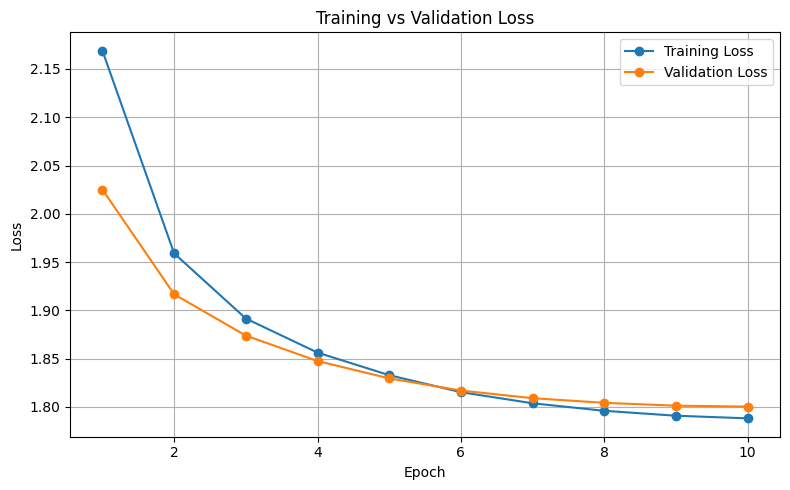

In [35]:
plt.figure(figsize=(8, 5))
plt.plot(df["Epoch"], df["Training Loss"], label="Training Loss", marker='o')
plt.plot(df["Epoch"], df["Validation Loss"], label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
from IPython.display import FileLink

FileLink("predictions.jsonl")

/kaggle/working/predictions.jsonl

In [41]:
!zip -r llama-3-3b-finetuned.zip llama-3-3b-finetuned/

  adding: llama-3-3b-finetuned/ (stored 0%)
  adding: llama-3-3b-finetuned/adapter_model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 7%)
  adding: llama-3-3b-finetuned/tokenizer.json (deflated 85%)
  adding: llama-3-3b-finetuned/README.md (deflated 66%)
  adding: llama-3-3b-finetuned/adapter_config.json (deflated 55%)
  adding: llama-3-3b-finetuned/special_tokens_map.json (deflated 71%)
  adding: llama-3-3b-finetuned/tokenizer_config.json (deflated 94%)


In [42]:
!zip -r llama-3-3b-sft-final.zip llama-3-3b-sft-final/

  adding: llama-3-3b-sft-final/ (stored 0%)
  adding: llama-3-3b-sft-final/adapter_model.safetensors (deflated 8%)
  adding: llama-3-3b-sft-final/tokenizer.json

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 85%)
  adding: llama-3-3b-sft-final/training_args.bin (deflated 51%)
  adding: llama-3-3b-sft-final/README.md (deflated 66%)
  adding: llama-3-3b-sft-final/adapter_config.json (deflated 55%)
  adding: llama-3-3b-sft-final/special_tokens_map.json (deflated 71%)
  adding: llama-3-3b-sft-final/tokenizer_config.json (deflated 94%)


In [43]:
from IPython.display import FileLink

# Link for model + tokenizer
display(FileLink("llama-3-3b-finetuned.zip"))

# Link for full trainer save
display(FileLink("llama-3-3b-sft-final.zip"))

/kaggle/working/llama-3-3b-finetuned.zip

/kaggle/working/llama-3-3b-sft-final.zip